# Pypam

## 0. Setup (install)

First we need to install all the packages which we need to exectue this notebook. You don't need to do this if you're using mybinder

In [ ]:
!pip install pvlib # This one is optional for the summary plot! 
!pip install git+https://github.com/lifewatch/pypam@feature/hmb_to_octaves # install pypam's latest version (from github)
!pip install minio # Install package to download the process

  Cloning https://github.com/lifewatch/pypam (to revision feature/hmb_to_octaves) to /tmp/pip-req-build-zyzrjas7
  Running command git clone --filter=blob:none --quiet https://github.com/lifewatch/pypam /tmp/pip-req-build-zyzrjas7
  Running command git checkout -b feature/hmb_to_octaves --track origin/feature/hmb_to_octaves


## 1. Download the data

We will download some processed HMB data stored in the cloud to give some examples of how can it be used. 
These data will be downloaded in this jupyterlab space, and you will be able to find them under the folder you specify here below, organized by station. 
Please change this line depending on where you want to store the data. 

We first start importing the packages we need for this part of the notebook

In [26]:
# Import the necessary packages
import minio
import os
import pathlib
from datetime import datetime

In [49]:
local_path = '/home/jovyan/work/shared/data'
max_days = 100
start_date_time = '2021-01-01'
end_date_time = '2021-02-01'

In [50]:
# Update end_date_time if defined temporal range exceeds max_days
time_delta = datetime.fromisoformat(end_date_time) - datetime.fromisoformat(start_date_time)
if time_delta.days > max_days:
    end_date_time = str(datetime.fromisoformat(start_date_time) + timedelta(days=max_days))
    print(f'end_date_time updated to {end_date_time}')

We will then start defining a function to download the data ONLY from the period we are interested in which can be then reused for different stations (then we don't need to write as much!)

In [55]:
# First we create a function to download data 
def download_data_station(station_name, 
                          client_obj, 
                          bucket_str, 
                          prefix_str, 
                          data_path,
                          name_format,
                          start_datetime, 
                          end_datetime):
    start_datetime_obj = datetime.fromisoformat(start_datetime) 
    end_datetime_obj = datetime.fromisoformat(end_datetime)
    station_folder = pathlib.Path(data_path).joinpath(station_name)
    if not station_folder.exists():
        os.mkdir(station_folder)
    objects = list(client_obj.list_objects(bucket_str, prefix=prefix_str))
    ct = 0
    for i, obj in enumerate(objects):
        object_name = obj.object_name
        path_name = pathlib.Path(object_name).name
        if (not path_name.startswith('.')) & path_name.endswith('.nc'):
            file_date = datetime.strptime(path_name, name_format)
            if (file_date >= start_datetime_obj) & (file_date <= end_datetime_obj):
                download_path = data_path + '/' + station_name + '/' + pathlib.Path(object_name).name
                if os.path.isfile(download_path):
                    print('Already downloaded: ' + download_path)
                else:
                    print('Download ' + str(ct) + ' of ' + str(len(objects)) + ': ' + download_path)
                    object_data = client.get_object(bucket, object_name)
                    if not os.path.isdir(download_path):
                        with open(str(download_path), 'wb') as file_data:
                            for data in object_data:
                                file_data.write(data)
                    file_data.close()
            else: 
                print('Ignored, out of selected period or not a netCDF file ' + path_name)
        ct += 1

Then we will download the data for 2 stations. 
For this workshop we have chosen MARS and NRS11, but feel free to change the station names here if you wish to play around with other stations from the same providers

Let's start with MARS. We first need to describe where the data are located

In [56]:
# Set up the download for MARS data
client = minio.Minio( "s3.us-west-2.amazonaws.com", secure=False)

bucket = 'pacific-sound-spectra'
prefix = '2021/'
station = 'MARS'
name_format = 'MARS_%Y%m%d.nc'
download_data_station(station, client, bucket, prefix, local_path, name_format=name_format, start_datetime=start_date_time, end_datetime=end_date_time)

Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210101.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210102.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210103.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210104.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210105.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210106.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210107.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210108.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210109.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210110.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210111.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210112.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_20210113.nc
Already downloaded: /home/jovyan/work/shared/data/MARS/MARS_2021

Then we move to the NRS11 data. We repreat the same process just with different parameters.
These are the data we can find at [sanctsound](https://console.cloud.google.com/storage/browser/noaa-passive-bioacoustic/sanctsound?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false), daily millidecade bands. 

In [59]:
# Set up the download for NRS11 data 
client = minio.Minio('storage.googleapis.com')
bucket = 'noaa-passive-bioacoustic'
station = 'NRS11'
prefix = 'soundcoop/%s/' % station
name_format = 'NRS11_H5R6.1.5000_%Y%m%d_DAILY_MILLIDEC_MinRes_v2.nc'
download_data_station(station, client, bucket, prefix, local_path, name_format=name_format, start_datetime=start_date_time, end_datetime=end_date_time)

Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191023_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191024_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191025_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191026_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191027_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191028_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191029_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191030_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected period or not a netCDF file NRS11_H5R6.1.5000_20191031_DAILY_MILLIDEC_MinRes_v2.nc
Ignored, out of selected per

## 2. Let's look at the data

We will first import all the packes we need to execut this part of the notebook

First we set some style guidelines for plotting

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Clear out default notebook settings
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

# Set figure size and layout
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True

In [3]:
# Import pypam modules 
import pypam.utils
import pypam.plots

In [4]:
# Import other tools
import pathlib
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Let's have a look at one of these netcdf files! You can click on the document sign or the database sign once the dataset is shown here below to get extra information. 

In [8]:
# Select one of the daily files
# you can browse through the daily netcdf files and select nay of the files we just downloaded, and copy the path here
ds = xr.open_dataset(local_path + '/NRS11/NRS11_H5R6.1.5000_20210103_DAILY_MILLIDEC_MinRes_v2.nc')

In [9]:
# Show the file information
ds

<xarray.Dataset>
Dimensions:             (time: 1440, frequency: 1195, cal_frequency: 3206)
Coordinates:
  * time                (time) datetime64[ns] 2021-01-03 ... 2021-01-03T23:59:00
  * frequency           (frequency) float64 0.0 1.0 2.0 ... 2.492e+03 2.498e+03
  * cal_frequency       (cal_frequency) float64 0.0 1.0 ... 2.556e+05 2.56e+05
Data variables:
    timestamp           (time) timedelta64[ns] ...
    effort              (time) timedelta64[ns] ...
    psd                 (time, frequency) float64 ...
    quality_flag        (time, frequency) int8 ...
    analog_sensitivity  (cal_frequency) float64 ...
    preamp_gain         (cal_frequency) float64 ...
    recorder_gain       (cal_frequency) float64 ...
    sensor_sensitivity  (cal_frequency) float64 ...
Attributes: (12/36)
    acknowledgement:                             These products support the P...
    citation:                                    Cite as: NOAA OAR Pacific Ma...
    comment:                                     Data quality: Good 2019-10-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Robert Dziak, Jason Gedamke,...
    creator_role:                                Principal Investigator
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                5000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:

We can then plot the long-term spectrogram of this day, selecting only the frequencies that we are interested in

<Axes: title={'center': 'Long Term Spectrogram'}, xlabel='Time', ylabel='Frequency [Hz]'>

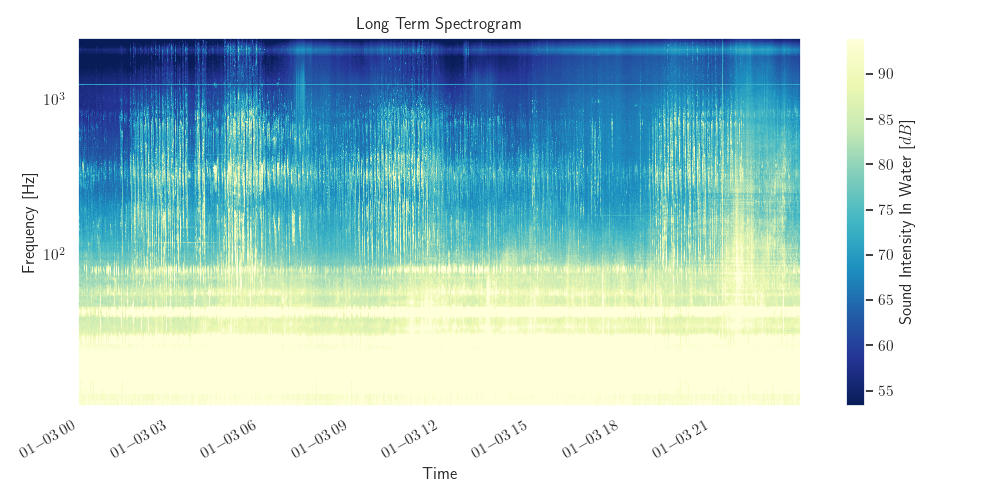

In [10]:
# Select the minimum and the maximum frequency
min_freq = 10
max_freq = 10000

# Plot the LTSA of one day
fig, ax = plt.subplots(figsize=(10, 5))
ds = pypam.utils.select_frequency_range(ds, min_freq=min_freq, max_freq=max_freq, freq_coord='frequency')
pypam.plots.plot_ltsa(ds=ds, data_var='psd', log=True, save_path=None, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')

We can also apply the quality flag to plot these data (only for data where it is available, not for MARS): 

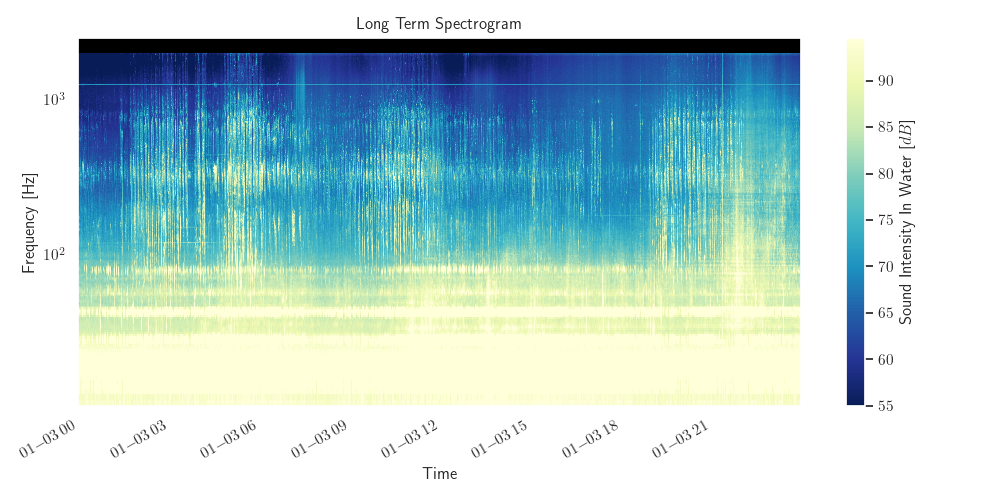

In [11]:
# Plot the LTSA of one day with the mask
minimum_quality = 2 # you can change this value depending on what you're interested in seeing. Check the ds quality_flag properties to see what each value (1 to 4) means
ds_masked = ds.copy() 
ds_masked['psd'] = ds_masked.psd.where(ds_masked.quality_flag < minimum_quality)
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_masked, data_var='psd', log=True, save_path=None, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_facecolor('black') # -> this allows us to see in black where the mask has been applied 

We can also specify the location and then the day/night patter will be shown. But then we need to install the pvblib package (already done at the beginning of the notebook)

First we will get where the location is from the metadata in the netdf file. We can find where is the property of that name when we were looking into the data some cells above.

In [12]:
location_str = ds.geospatial_bounds.replace('(', '').replace(')', '').split(' ')[1:]
location = [float(l) for l in location_str]

/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


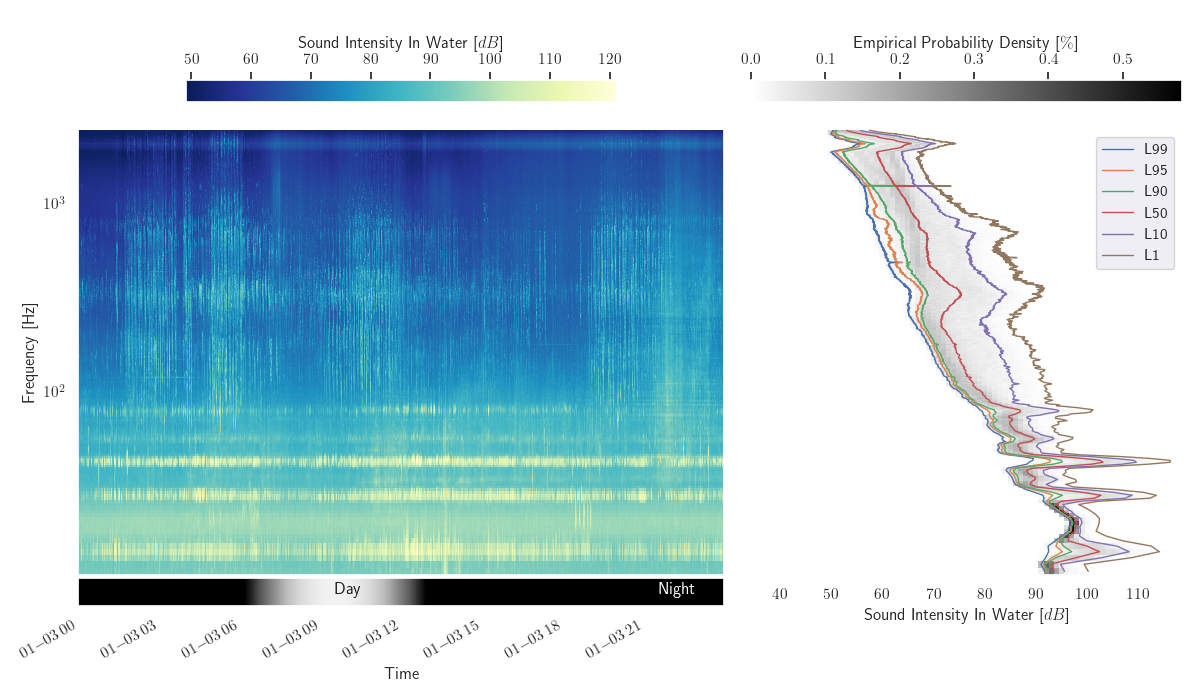

In [13]:
# Lon, Lat
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
percentiles = [1, 5, 10, 50, 90, 99]
pypam.plots.plot_summary_dataset(ds, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=location)

## 3. Long-term plotting

In this section we will show some tools for resampling data and long-term plotting. For this, we can load all the computed daily millidecade bands in one xarray dataset for each station, and we will save the output as one file (a full year per station!). 
For this we will load the data using  the join_all_ds_output_deployment of pypam, which uses Dask parallel computing for fast access. 

We will load only a part of the data (in frequency range), because the MARS data has spectrum values up to 100 kHz, and we want to keep it light. 

In [14]:
RESAMPLE_RESOLUTION = '1h' # we could also set it to 1d for daily resolution for example
min_freq = 10
max_freq = 10000

In [15]:
# Only get data from 2021
def load_data_from_station_year(station, year, data_vars):
    deployment_path = pathlib.Path(local_path).joinpath(station)
    print('loading station %s...' % station)
    aggregated_ds = pypam.utils.join_all_ds_output_deployment(deployment_path, data_vars=data_vars, datetime_coord='time',
                                                              join_only_if_contains='_%s' % year, load=True,
                                                              parallel=False, freq_band=[min_freq, max_freq],
                                                              freq_coord='frequency',
                                                              drop_variables=['psd_image_colormap',
                                                                              'psd_image',
                                                                              'percentile_image',
                                                                              'percentile_image_colormap'])
    return aggregated_ds # this assigns an xarray dataset

<div class="alert alert-block alert-info">
⚠️ Be patient, loading two full years can take a while...
</div>

In [16]:
# Load the data for each station
# Quality flag is only available for NRS11, not for MARS. We can decide to ignore it or load it by removing it from the data_vars list 
ds_collection = {}
ds_collection['MARS'] = load_data_from_station('MARS', , data_vars=['psd'])
ds_collection['NRS11'] = load_data_from_station('NRS11', 2021, data_vars=['psd', 'quality_flag'])

loading station MARS...
[########################################] | 100% Completed | 6.19 sms
loading station NRS11...
[########################################] | 100% Completed | 38.52 s


### Plot the HMB as yearly long-term spectrograms

For memory reasons, plotting 1-minute resolution spectrograms for a full year is not possible. Therefore, we need to downsample the data (by taking the median, because values are in db). We can downsample it to hours or days.

In [17]:
station_to_plot = 'NRS11' # By changing these value all the plots below will be for the selected stations. Feel free to change this name to any of the loaded stations

First let's look at how the full dataset looks like (not resampled)

In [49]:
ds_collection[station_to_plot]

<xarray.Dataset>
Dimensions:       (time: 398992, frequency: 1184)
Coordinates:
  * time          (time) datetime64[ns] 2021-01-01 ... 2021-10-05T00:59:00
  * frequency     (frequency) float64 11.0 12.0 13.0 ... 2.492e+03 2.498e+03
Data variables:
    psd           (time, frequency) float64 92.8 92.6 92.8 ... 50.3 50.4 nan
    quality_flag  (time, frequency) int8 1 1 1 1 1 1 1 1 1 ... 4 4 4 4 4 4 4 4 4
Attributes: (12/36)
    acknowledgement:                             These products support the P...
    citation:                                    Cite as: NOAA OAR Pacific Ma...
    comment:                                     Data quality: Good 2019-10-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Robert Dziak, Jason Gedamke,...
    creator_role:                                Principal Investigator
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                5000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:

<div class="alert alert-block alert-info">
⚠️ Be patient, resampling a full year can take a little while...
</div>

In [50]:
# Need to resample first, otherwise there is too much data to plot!
ds_resampled = ds_collection[station_to_plot].resample(time=RESAMPLE_RESOLUTION).median()

And this is the resampled dataset!

In [51]:
ds_resampled

<xarray.Dataset>
Dimensions:       (time: 6649, frequency: 1184)
Coordinates:
  * frequency     (frequency) float64 11.0 12.0 13.0 ... 2.492e+03 2.498e+03
  * time          (time) datetime64[ns] 2021-01-01 ... 2021-10-05
Data variables:
    psd           (time, frequency) float64 93.55 92.6 94.2 ... 56.2 56.3 nan
    quality_flag  (time, frequency) float64 1.0 1.0 1.0 1.0 ... 4.0 4.0 4.0 4.0
Attributes: (12/36)
    acknowledgement:                             These products support the P...
    citation:                                    Cite as: NOAA OAR Pacific Ma...
    comment:                                     Data quality: Good 2019-10-2...
    conventions:                                 COARDS, CF-1.6, ACDD-1.3
    creator_name:                                Robert Dziak, Jason Gedamke,...
    creator_role:                                Principal Investigator
    ...                                          ...
    title:                                       Hybrid Millidecade Band Soun...
    PreampFixedGain_dB:                          0.0
    SamplingRate:                                5000
    CalibrationFrequency_Hz:                     0.0
    CalibrationSensitivity_dB_re_1VperRefPress:  0.0
    CalibrationDate:

We can plot the LTSA also for an entire year

Text(0.5, 1.0, 'NRS11')

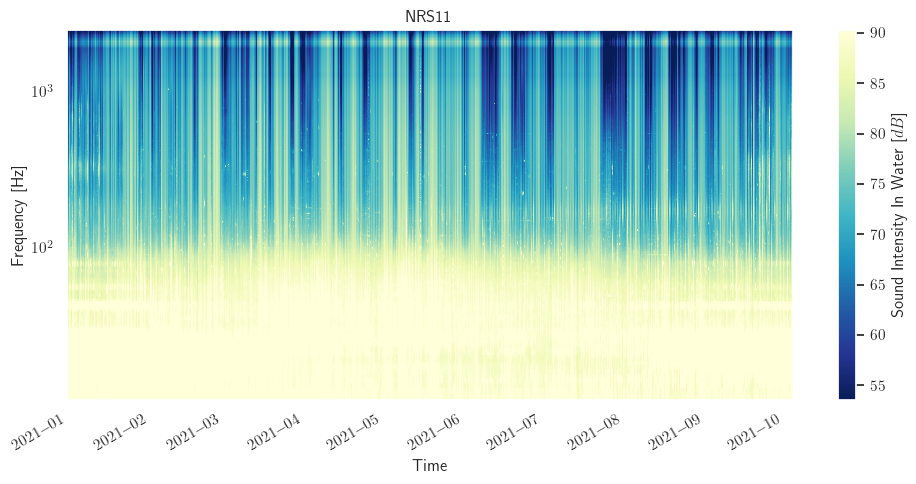

In [53]:
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_resampled, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_title(station_to_plot)
plt.show()

And if it is available, we can plot a mask with the quality flag. 
First we will resample the quality flag so any hour has the flag of its worst minute

In [73]:
minimum_quality = 2
ds_mask = ds_collection[station_to_plot].quality_flag.resample(time=RESAMPLE_RESOLUTION).max()
ds_mask['psd'] = ds_resampled.psd
ds_mask['psd'] = ds_mask.psd.where(ds_mask < minimum_quality)

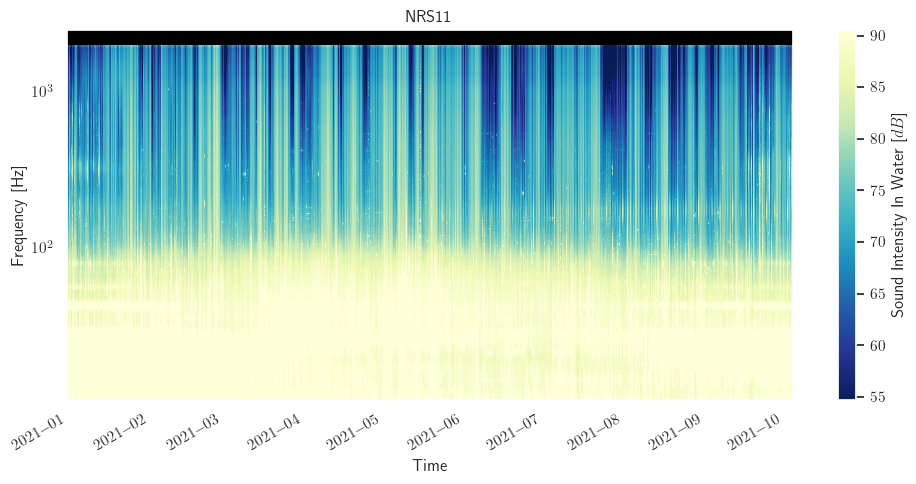

In [74]:
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=ds_mask, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.set_title(station_to_plot)
ax.set_facecolor('black') # -> allows us to see where the quality flag has been applied
plt.show()

### Plot the SPD

In [75]:
# First, convert the HMB output to SPD like we did for the small wav files examples
percentiles = [1, 10, 50, 90, 99]
min_psd = 35 # in db
max_psd = 120 # in db
h = 1 # in db
ds_spd = pypam.utils.compute_spd(ds_resampled, data_var='psd', percentiles=percentiles, min_val=min_psd, 
                                 max_val=max_psd, h=h)

/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


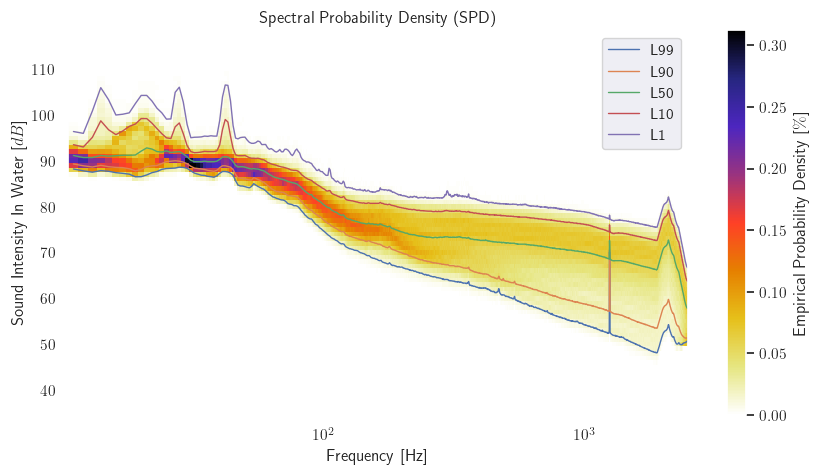

In [76]:
# Plot the obtained output
fig, ax = plt.subplots(figsize=(10,5))
pypam.plots.plot_spd(spd=ds_spd, log=True, save_path=None, ax=ax, show=False)
plt.show()

### Plot a summary

We can also make the same summary plot for the entire year, not only for one day (but then we don't show day/night as it would be too busy)

/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


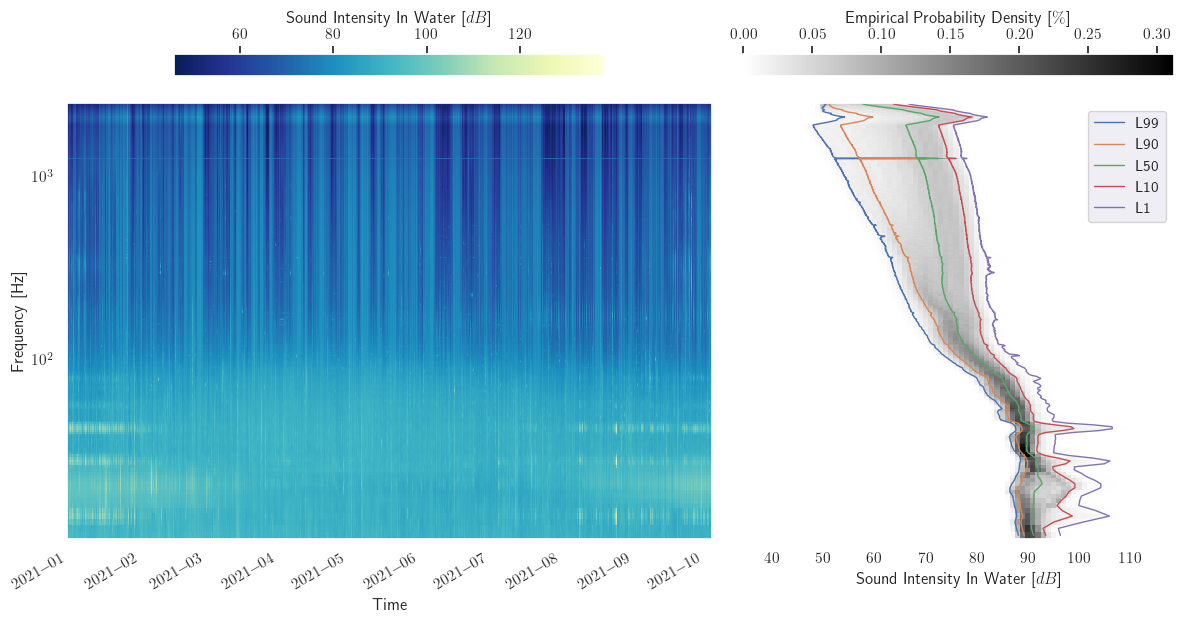

In [77]:
pypam.plots.plot_summary_dataset(ds_resampled, percentiles, data_var='psd', time_coord='time', freq_coord='frequency',
                                 min_val=min_psd, max_val=max_psd, show=True, log=True, save_path=None,
                                 location=None)

## 4. Whale presence indices

Indices are the ratio of mean power spectral density (PSD) within the frequency band of peak call energy to mean PSD at background frequencies.
These peak and background frequencies will be illustrated in the summary plot and call index calculations below

In [78]:
# Define the frequencies that are used to compute call indices
bluepeak = np.array([42, 43])
finpeak = np.array([20, 21])
bluebackground = np.array([37, 50])
finbackground = np.array([12, 34])

We can plot a LTSA with a line showing these values, but we will resample it first to daily spectra to get daily indices. 
Be patient, resampling a full year can take a little while...

In [79]:
whale_station1 = 'MARS' # Choose the station you want to plot
daily_resampled1 = ds_collection[whale_station1].resample(time='1D').median()  # Resample to daily spectra

In [80]:
whale_station2 = 'NRS11' # Choose the second station you want to plot
daily_resampled2 = ds_collection[whale_station2].resample(time='1D').median()  # Resample to daily spectra

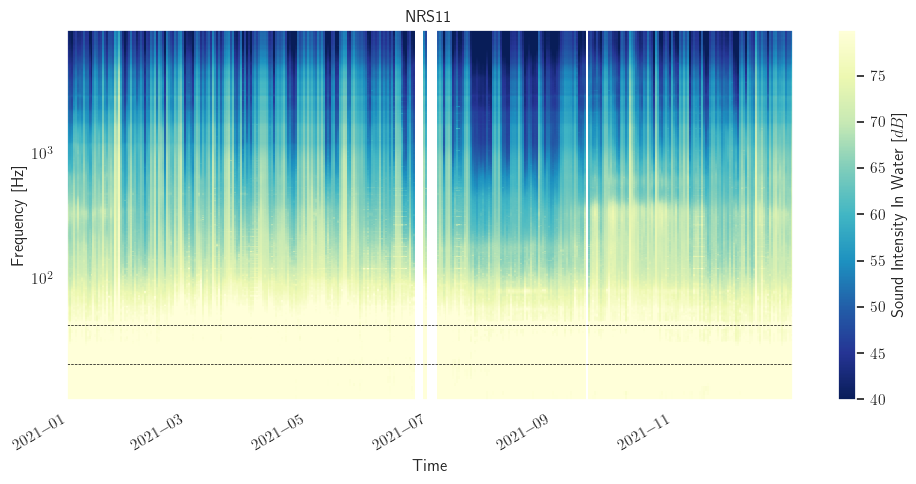

In [81]:
# Then, plot the LTSA
fig, ax = plt.subplots(figsize=(10, 5))
pypam.plots.plot_ltsa(ds=daily_resampled1, data_var='psd', log=True, ax=ax, show=False, freq_coord='frequency',
                      time_coord='time')
ax.axhline(np.mean(bluepeak),color='black',linestyle='--',linewidth=0.5)
ax.axhline(np.mean(finpeak),color='black',linestyle='--',linewidth=0.5)
ax.set_title('NRS11')
plt.show()

In [82]:
def compute_whale_index(peak, background, daily_ds):
    pk = daily_ds.sel(frequency=peak).psd.mean(dim='frequency')
    bg = daily_ds.sel(frequency=background).psd.mean(dim='frequency')
    CI = pk / bg
    return CI

In [83]:
# Compute the whale indices
finCI1 = compute_whale_index(finpeak, finbackground, daily_resampled1)
blueCI1 = compute_whale_index(bluepeak, bluebackground, daily_resampled1)
finCI2 = compute_whale_index(finpeak, finbackground, daily_resampled2)
blueCI2 = compute_whale_index(bluepeak, bluebackground, daily_resampled2)

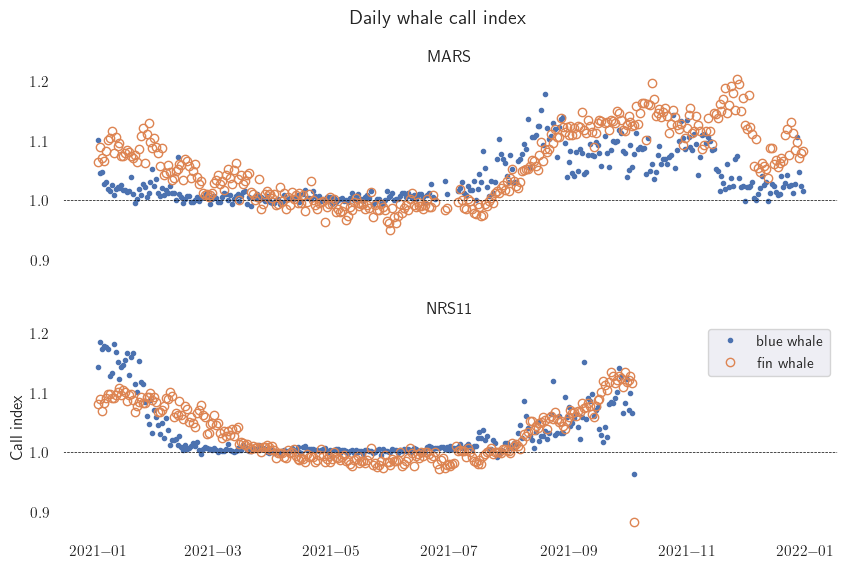

In [84]:
# Plot the whale indices
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True, sharey=True)
ax[0].plot(daily_resampled1.time.values, blueCI1, '.', label='blue whale')
ax[0].plot(daily_resampled1.time.values, finCI1, 'o', markerfacecolor='none', label='fin whale')
ax[0].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[0].set_facecolor('white')
ax[0].set_title(whale_station1)

ax[1].plot(daily_resampled2.time.values, blueCI2, '.', label='blue whale')
ax[1].plot(daily_resampled2.time.values, finCI2, 'o', markerfacecolor='none', label='fin whale')
ax[1].axhline(1, color='black', linestyle='--', linewidth=0.5)
ax[1].set_facecolor('white')
ax[1].set_title(whale_station2)

plt.suptitle('Daily whale call index')
plt.ylabel('Call index')
plt.legend()
plt.show()

## 5. Daily patterns

We can plot the hourly data we have obtained for the entire year to see if there are any daily patterns which repeat

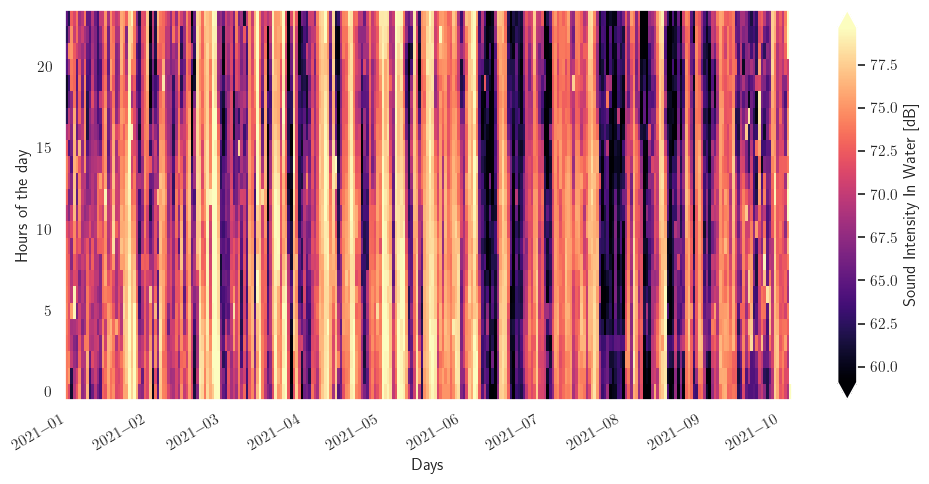

<Axes: xlabel='Days', ylabel='Hours of the day'>

In [85]:
fig, ax = plt.subplots(figsize=(10, 5))
ds_freq = pypam.utils.freq_band_aggregation(ds_resampled, data_var='psd', aggregation_freq_band=[10, 20])
pypam.plots.plot_daily_patterns_from_ds(ds=ds_freq, data_var='psd', show=True, datetime_coord='time', ax=ax)

## 6. Compare data between stations

We can compare the spectrums of two locations, by visualizing the median and the [10, 90] percentile spectrum of each location.
We first need to resample it to hourly median resolution for faster plotting. 

<div class="alert alert-block alert-info">
⚠️ Be patient, resampling a two stations can take even a longer while...
</div>

In [86]:
# Spectral Density comparison
ds_collection_resampled = {'NRS11': ds_collection['NRS11'].resample(time='1h').median(), 
                           'MARS': ds_collection['MARS'].resample(time='1h').median()}

/opt/conda/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1577: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


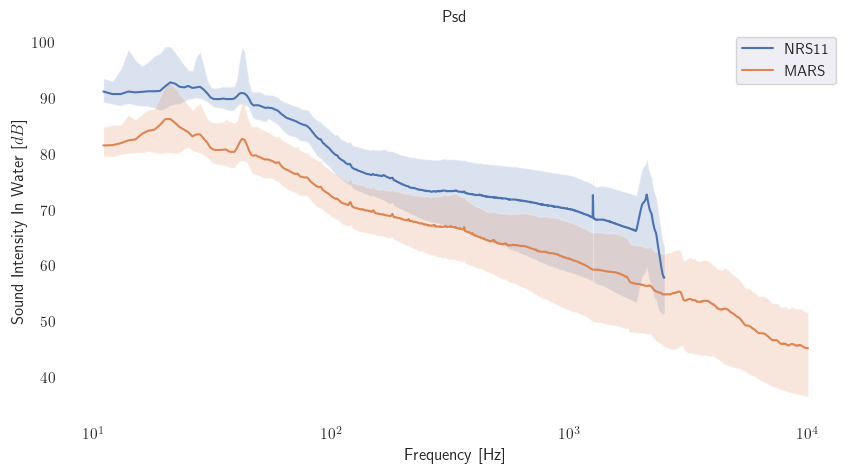

In [87]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = pypam.plots.plot_multiple_spectrum_median(ds_collection_resampled, 'psd', percentiles='default', 
                                               frequency_coord='frequency',
                                               log=True, save_path=None, 
                                               ax=ax, show=True, time_coord='time')

### Aggregations and boxplots

We can now plot the evolution of all the stations by calling the bin aggregation function. It will compute the median of all the values included in the frequency band specified.
Then it will aggregate all the values of the dataset in time to match the specified time frequency. 
PyPAM has a function to plot the evolution of one or multiple stations. 

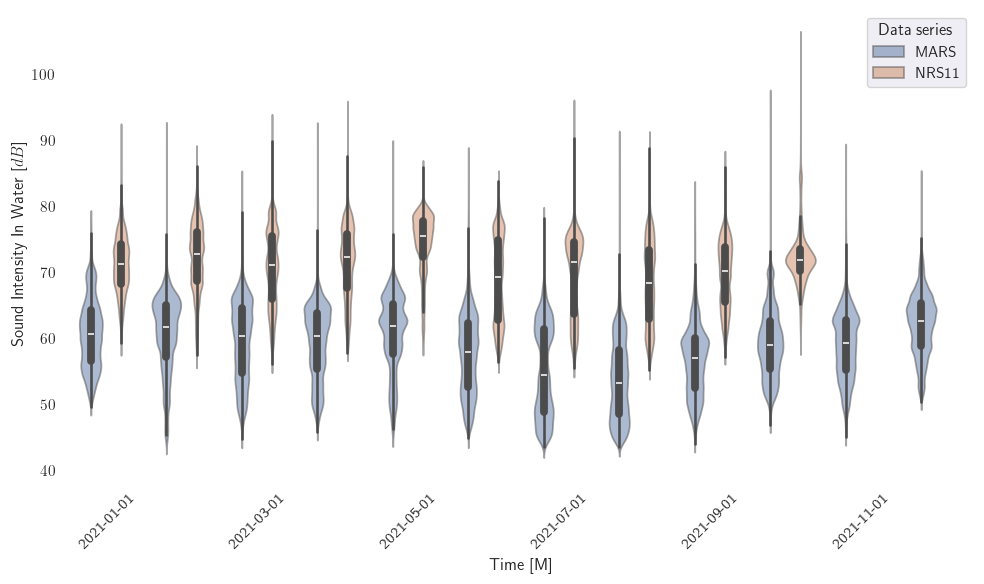

<Figure size 640x480 with 0 Axes>

In [88]:
aggregation_time = 'M'  # h, D, W, or M (hour, day, week or month)
aggregation_freq_band = [10, 200]
mode = 'violin'  # It can be boxplot, violin or quantiles
fig, ax = plt.subplots(figsize=(10, 6))
ax = pypam.plots.plot_multiple_aggregation_evolution(ds_dict=ds_collection,
                                                     data_var='psd',
                                                     mode=mode,
                                                     show=True,
                                                     datetime_coord='time',
                                                     aggregation_time=aggregation_time,
                                                     freq_coord='frequency',
                                                     aggregation_freq_band=aggregation_freq_band,
                                                     ax=ax,
                                                     alpha=0.5)
ax.set_title('Median sound intensity in water from frequency band %s to %s Hz' %
             (aggregation_freq_band[0], aggregation_freq_band[1]))
plt.tight_layout()

## 7. Conversions: from HMB to decidecade bands

We will work only with one day of data, just to show it (it will be faster!)

In [89]:
ds = xr.open_dataset(local_path + '/MARS/MARS_20210316.nc')

# Convert back to upa for the sum operations
ds_decidecades = pypam.utils.hmb_to_decidecade(ds, 'psd', freq_coord='frequency', fs=256000)

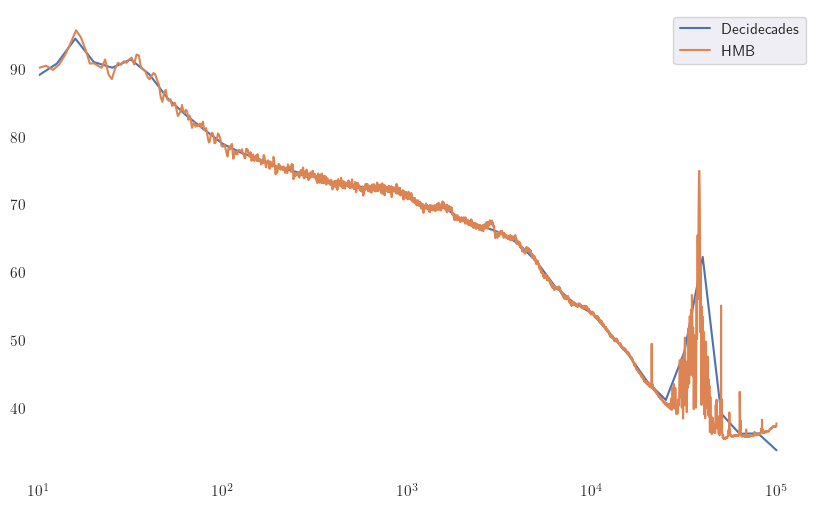

In [90]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(ds_decidecades.frequency, ds_decidecades['psd'].isel(time=0), label='Decidecades')
ax.plot(ds.frequency, ds['psd'].isel(time=0), label='HMB')
plt.xscale('symlog')
plt.xlim(left=10)
ax.set_facecolor('white')
plt.legend()
plt.show()